In [ ]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz' # path for the data, needs to be adjusted accordingly

In [ ]:
num_of_states = 50     # this needs be changed to the desired number of states

In [1]:
# data preperation code

import pandas as pd
import numpy as np
import gzip

file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz' # path for the data

def cps_data(file_path):
  
    df = pd.read_csv(file_path, compression='gzip', header=0) # importing the data

    
    df = df[(df['INCWAGE'] != 99999999) & (df['INCWAGE'] != 0) & (df['INCWAGE'] != 999)]  # dropping the rows containing invalid INCWAGE

    df = df[(df['EDUC'] != 0) & (df['EDUC'] != 1)]  # dropping education levels 0 and 1 as they are invalid entries as per the labels of the dataset

    df = df[(df['YEAR'] >= 1980) & (df['YEAR'] <= 2000)]  # taking the time frame from 1980 to 2000

    def categorize_education(educ_code): # creating a fucntion to categorize education levels
        if educ_code <= 10:
            return 'Up to Grade 10'
        elif 10 < educ_code <= 70:
            return 'High School'
        elif 70 < educ_code <= 123:
            return "Master's Degree"
        else:
            return 'Doctorate Degree'

    
    df['Education_Category'] = df['EDUC'].apply(categorize_education) # applying the function to create a new 'Education_Category' column

    df = pd.get_dummies(df, columns=['Education_Category'], prefix='', prefix_sep='', drop_first=True)

    boolean = ['Up to Grade 10', 'High School', "Master's Degree"]
    df[boolean] = df[boolean].astype(int)

    df = df[~((df['STATEFIP'] > 56) | (df['STATEFIP'] == 11))]  # taking only the 50 states of the States and exclusing the regions as per the labels of the dataset

    df = df[(df['AGE'] >= 25) & (df['AGE'] <= 50)]  # taking the age group from 25 to 50

    df = df[df['SEX'] == 2] # taking only female respondents

    return df

In [2]:
# the function is necessary to extract the standard error values from the wildboottest result table

def calculate_standard_error(t_statistic, parameter_estimate):
    """
    Calculate the standard error given a t-statistic and the parameter estimate.
    
    Parameters:
    t_statistic (float): The t-statistic value.
    parameter_estimate (float): The estimated parameter value (e.g., mean difference).
    
    Returns:
    float: The calculated standard error.
    """
    if t_statistic == 0:
        raise ValueError("t_statistic cannot be zero.")
    return abs(parameter_estimate / t_statistic)


Number of times null hypothesis is rejected: 406 out of 500 simulations
Type 1 Error: 0.812
Bias for Coefficient of Treatment : -0.0005944960835956165
MSE for Coefficient of Treatment : 0.0002613658776699326
RMSE for Coefficient of Treatment : 0.01616681408533953
Average Standard Error: 0.01736875232062602
Standard Error of the beta_1 distribution: 0.016155879798900527
The confidence interval is (0.017739979510559355, {0.08107102832224941})


Text(0.5, 1.0, 'Distribution of $\\beta_1$ Estimates')

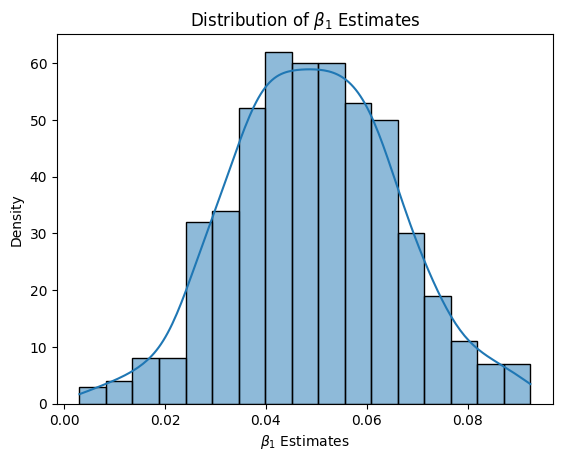

In [3]:


import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smp
from wildboottest.wildboottest import wildboottest
import warnings

alpha = 0.05      # Significance level
num_simulations = 500


np.random.seed(42)

reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0.05   # as we are introducing a 5% effect
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []


df = cps_data(file_path = file_path)

for _ in range(num_simulations):
   
    data = df.copy()

    unique_statefips = data['STATEFIP'].unique()
    selected_statefips = np.random.choice(unique_statefips, size=num_of_states, replace=False)

    # Filter the DataFrame to only include rows with the selected STATEFIPs
    data = data[data['STATEFIP'].isin(selected_statefips)]
    
    states = data['STATEFIP'].unique()
    
    # Randomly selecting  half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assigning treatment year to each treatment state, staggered between 1985 and 1995

    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame

    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)

    data['outcome'] = data.apply(lambda x: x['INCWAGE']*(1.05) if x['TREATMENT'] == 1 else x['INCWAGE'], axis=1)  # to simulate the 5% effect 

    data['outcome'] = np.log(data['outcome'])

    # Data aggregation is being done after the 5% effect has been introduced

    X = data[['High School', "Master's Degree", 'AGE']]
    y = data['outcome']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)   # Obtain predicted values from the fitted model

    residuals = y - y_pred

    data['Residuals'] = residuals

    cps_agg = data.groupby(['STATEFIP', 'YEAR'])[['Residuals', 'TREATMENT']].mean().reset_index()

    dummy_df_state = pd.get_dummies(cps_agg['STATEFIP'], prefix='STATEFIP', drop_first=True).astype(int)  # One-hot encode STATEFIP and YEAR
    dummy_df_year = pd.get_dummies(cps_agg['YEAR'], prefix='YEAR', drop_first=True).astype(int)

    cps_agg = pd.concat([cps_agg, dummy_df_state, dummy_df_year], axis=1)
    data = cps_agg.copy()
    columns_to_exclude = ['STATEFIP', 'YEAR', 'Residuals']

    X_columns =[col for col in data.columns if col not in columns_to_exclude]

    warnings.filterwarnings("ignore")
    
    formula = "Residuals ~ "
    
    formula += " + ".join(X_columns)

    model = smp.ols(formula = formula , data = data)

    result = model.fit()
    wildboottest_results = wildboottest(model, param="TREATMENT", cluster=data['STATEFIP'], B= 400, bootstrap_type='11', show = False)
    wildboottest_results = pd.DataFrame(wildboottest_results)
    p_value = wildboottest_results['p-value'].iloc[0]
    param = result.params['TREATMENT']
    t_stat = wildboottest_results['statistic'].iloc[0] 


    # Checking  if null hypothesis for beta1 is rejected

    if p_value < alpha:
        reject_count += 1

    beta1_estimates.append(param)

    bias = np.mean(beta1_estimates) - true_beta1_value

    squared_error = (param - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    # Extracting the standard error of the 'TREATMENT' coefficient 

    standard_error = calculate_standard_error(t_stat, param)
    standard_error_values.append(standard_error)


type1_error = reject_count/ num_simulations
bias = np.mean(bias)
mse = np.mean(squared_error_values)
rmse = np.sqrt(mse)
average_standard_error = np.mean(standard_error_values)


std_error_beta_distribution = np.std(beta1_estimates)  # Calculating the standard error of the distribution of beta

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {rmse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.histplot(beta1_estimates, kde = True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')
